Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Требуется провести анализ и подготовить план действий по удержанию клиентов.
Выявить какие признаки влияют на отток клиентов. Также класетризовать клиентов и проверить какие группы клиентов менее оттекаемые.

## Инициализация данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, accuracy_score, precision_score, recall_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage 

In [2]:
data = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


## Подготовка данных. EDA

In [4]:
# приведем названия к единому стилю
data.columns = [x.lower().replace(' ', '_') for x in data.columns]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [6]:
# взглянем не пропуски
data.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

In [7]:
# проверим наличие дубликатов
data.duplicated().sum()

0

Типы данных в порядке, пропуски отсутствуют, явных дубликатов не обнаружено, переходим к оценкам распределений признаков

In [8]:
# рассмотрим среднии и стандартные отклонения по всем колонкам датафрейма
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [9]:
# посмотрим среднее по оттоку и оставшимся
data.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Значения распределены более менее равномерно, выбросов не наблюдается

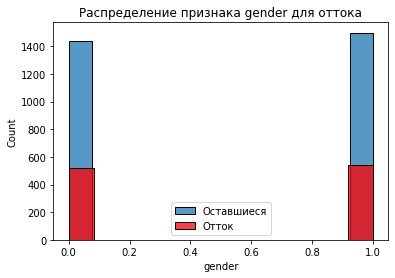

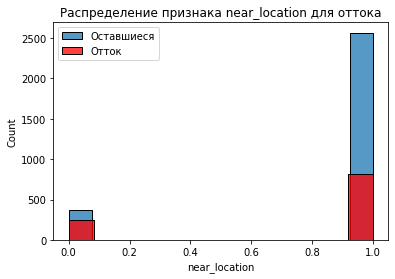

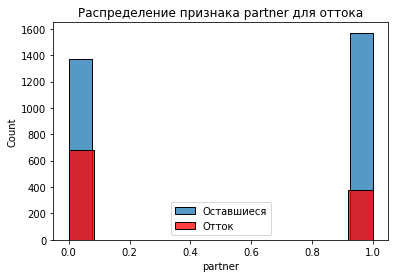

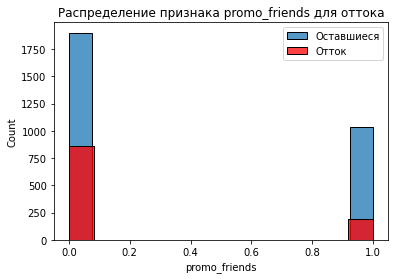

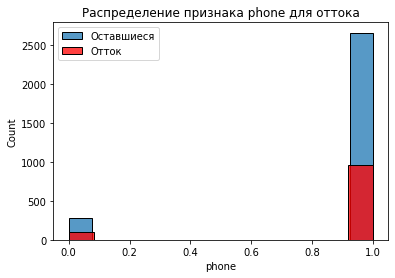

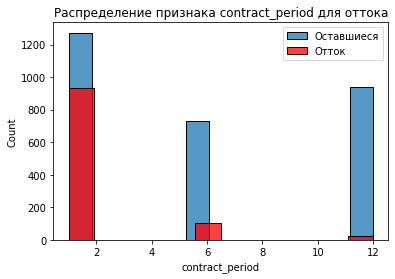

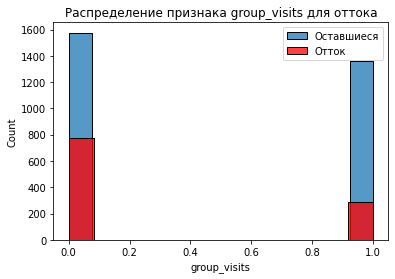

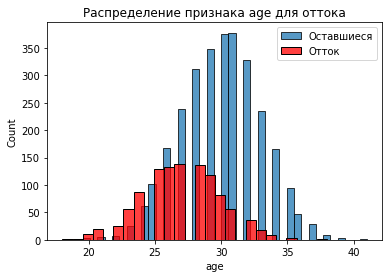

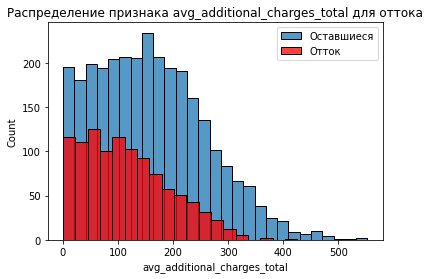

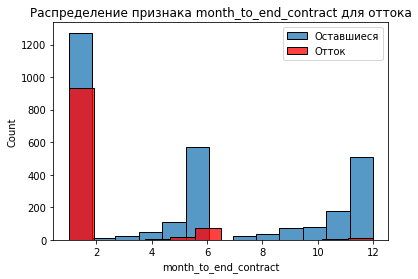

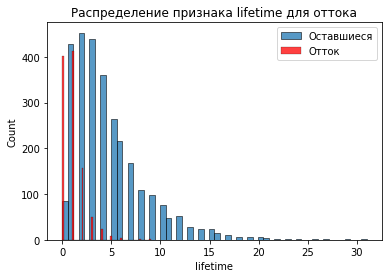

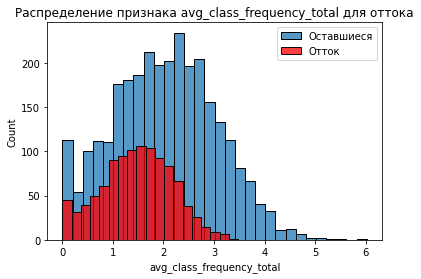

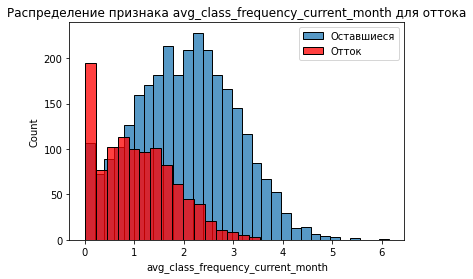

In [10]:
# напишем цикл для отрисовки признаков оставшихся и ушедших клиентов
for col in data.drop(columns='churn').columns:
    sns.histplot(data=data, x=data.query('churn==0')[col])
    plt.title('Распределение признака {} для оставшихся клиентов'.format(col))
    #plt.show()
    sns.histplot(data=data, x=data.query('churn==1')[col], color='red')
    plt.title('Распределение признака {} для оттока'.format(col))
    plt.legend(['Оставшиеся','Отток'])
    plt.show()

Партнерские клиенты чаще остаются, также наиболее часто оттекающие клиенты с месячным абонементом. Чаще всего уходят в первый месяц или второй после первого посещения. Посетители групповых занятий реже оттекают

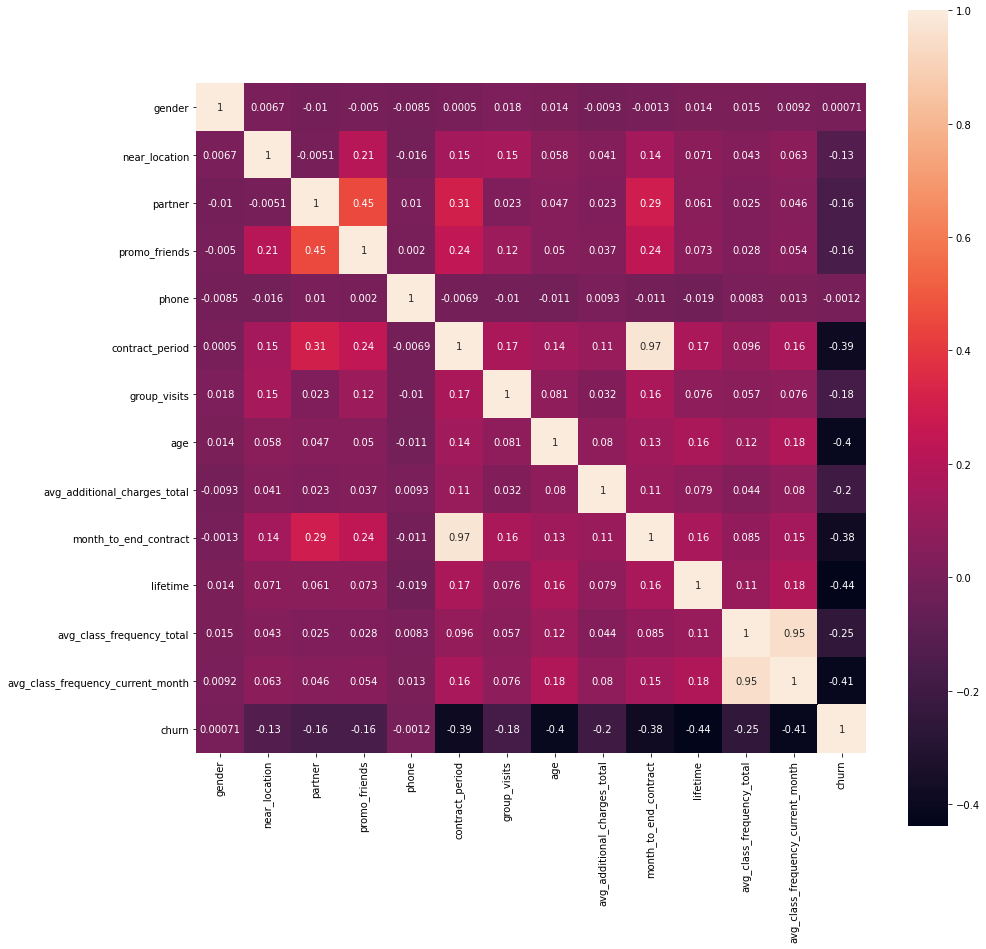

In [11]:
# матрица корреляций, представленная тепловой картой
plt.figure(figsize=(15,15))
sns.heatmap(data=data.corr(),square=True, annot=True)
plt.show()

Большинство признаков слабо коррелируют, а некоторые и вовсе не приносят никакого влияния. Самые ярко коррелирующие с целевой переменной признаки это lifetime, contract_period, avg_class_frequency_current_month. Конечно есть и парные коррелирующие признаки, которые бы стоило учесть при построении линейных моделей, но проверять будем не их.

### Вывод
Исследовательский анализ данных показал, что признаки распределены близко к нормальному, классы распеделены равномерно. В данных отсутствуют пропуски, дубликаты, выбросы. Средние значения и стандартные отклонения признаков тоже не вызывают подозрений. Предположительно признаки lifetime, contract_period, avg_class_frequency_current_month, age влияют на отток. Но в своем большинстве эта связь является очень слабой и иногда просто слабой

## Модель прогнозирования оттока клиентов

In [12]:
# разделяем модель на обучающую и валидационную выборку
X = data.drop(columns=('churn'))
y = data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Проверим результат деления выборок
X_train.shape

(3200, 13)

In [13]:
# обозначим список моделей которые будем обучать
models = [
    LogisticRegression(random_state=0,solver='liblinear'),
    RandomForestClassifier(random_state=0)
]

# функция, которая принимает на вход модель и данные и выводит метрики 
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f} R2:{:.2f} '.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            r2_score(y_test, y_pred),
        )
    )

In [14]:
# цикл для прогонки моделей и получения метрик по ним
for i in models:
    print(i)
    make_prediction(i, X_train, y_train, X_test, y_test)

LogisticRegression(random_state=0, solver='liblinear')
Accuracy:0.93 Precision:0.86 Recall:0.83 R2:0.60 
RandomForestClassifier(random_state=0)
Accuracy:0.92 Precision:0.84 Recall:0.82 R2:0.55 


Логистическая регрессия показывает себя лучше по всем показателям. Возможно применив разные настройки для случайного леса, можно было бы получить лучшие результаты.

### Вывод
Модель бинарной классификации оттока клиентов была выбрана Логистическая регрессия. Она показала себя лучше по всем метрикам на валидационной выборке и может быть использована для дальнейшей классификации.

## Кластеризация клиентов

In [15]:
# стандартизация данных
sc = StandardScaler()
X_sc = sc.fit_transform(X)

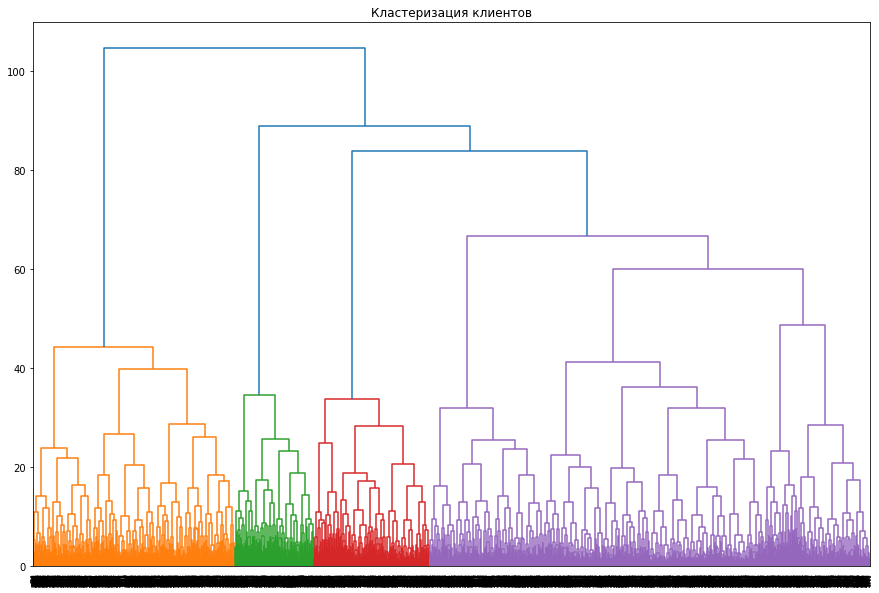

In [16]:
# отрисовка дендограммы
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов')
plt.show() 

На дендограмме присутствует один класс который превалирует над другими свои размером, предположительно его можно было бы поделить на 2 класса и получилась бы хорошая кластеризация. Для К-среднего возьмем как раз таки 5 кластеров и обучим модель.

In [17]:
# задаем модель и обучаем ее
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)
data['cluster_km'] = labels

In [18]:
# выводим статистику по средним значениям признаков по кластеру
display(data.groupby('cluster_km').mean().T)

cluster_km,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


Кластер 2 имеет ярко выраженный сегмент клиентов живущих далеко от спорт зала и они почти не посещают групповые занятия и их не приглашали друзья. В отток уходят чаще остальных 

Кластер 1 выделяется на основании отсутсвия указанного клиентами номера телефона, они покупали 6 месячный абонемент и проходили в зал уже более 3 месяцев в среднем. В отток уходят реже, но достаточно.

Кластер 4 это наиболее часто приходящие в зал, они живут близко и больше всего тратят в зале денег, так же в зал они ходят уже давно более 4 месяцев, но абонемент у них не более 6 месяцев. Такие клиенты очень редко уходят в отток

Кластер 0 лидер по остающимся клиентам и сразу видно почему: у клиентов 12 месячный абонемент, они живут близко к залу, и покупали абонемент от партнеров, так же их приглашали друзья, они тратят много денег в зале и ходят в него достаточно часто, так еще и посещяют групповые занятия чаще остальных.

Класетр 3 является средним кластером в котором выделяется, только то что клиенты живут в прямой близости к залу и вероятнее всего у них абонементы на маленький срок, они не так часто приходят, тратя меньше всех денег, в общем чаще всего и уходят в отток.

In [19]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.14


Дополнительная оценка класетризации пригодится, не так уж и плохо, учитывая, что чаще всего нет явной структуры данных из которой можно выделить определенные кластеры

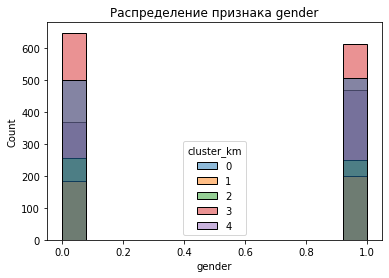

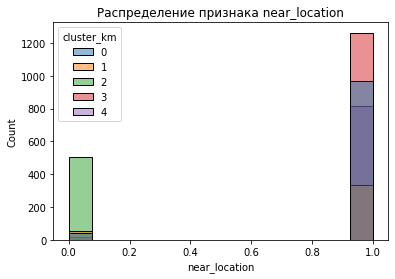

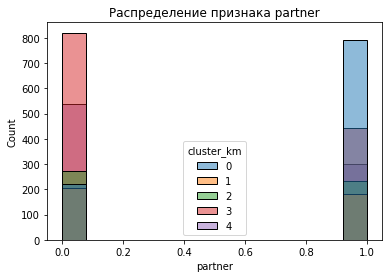

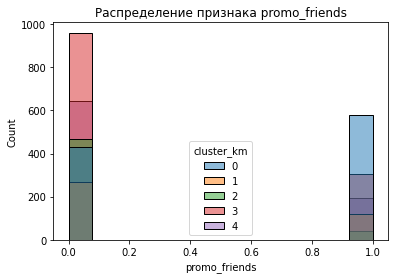

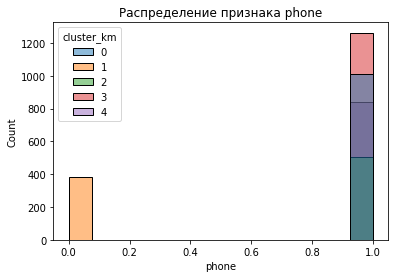

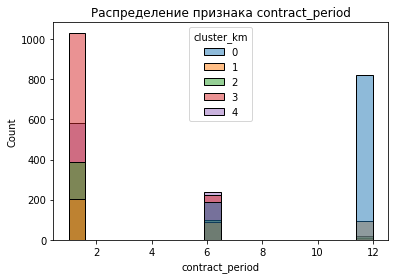

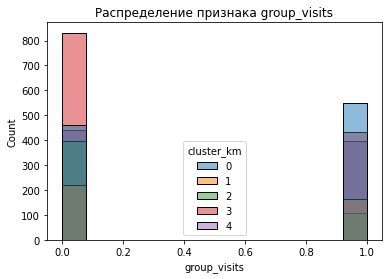

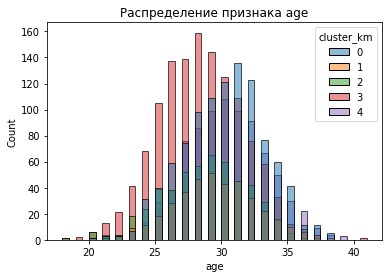

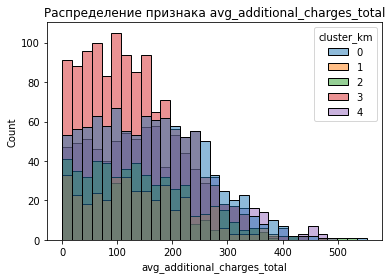

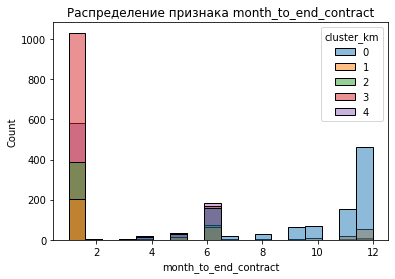

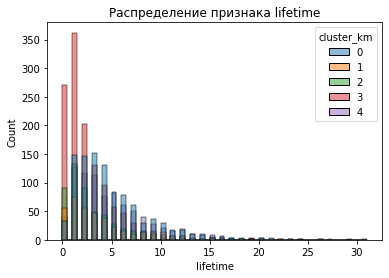

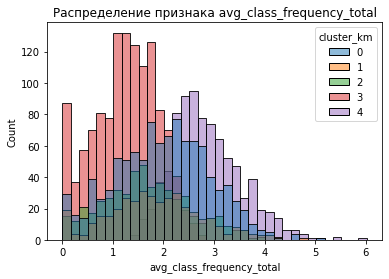

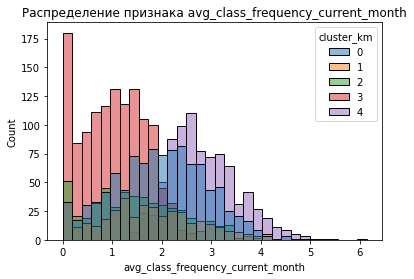

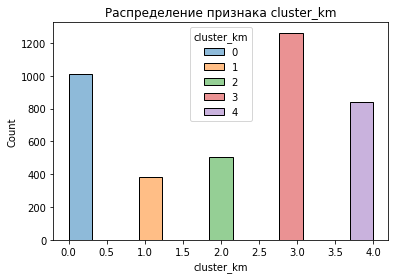

In [20]:
for col in data.drop(columns='churn').columns:
    sns.histplot(data=data, x=data[col], hue=data['cluster_km'], palette="tab10")
    plt.title('Распределение признака {}'.format(col))
    plt.show()

Как раз таки наиболее оттекающий кластер и является наиболее распространеным это кластер 3. Наименее оттекающие кластеры это 0,1,4

Подтверждается большинство предположений сделанных выше. Кластер 3, чаще берется на маленькое количество месяцев, не так часто ходит в зал и в неделю и в месяц, его первый визит в зал не позже 3 месяцев назад и тратит не так много денег, чаще всего не партнерский клиент и не приведенный другом. Также живет в непосредственной близости к залу.

In [21]:
print('доля оттока для кластеров',data.groupby('cluster_km')['churn'].count()/len(data))

доля оттока для кластеров cluster_km
0    0.25250
1    0.09625
2    0.12625
3    0.31550
4    0.20950
Name: churn, dtype: float64


Наиболее надежными оказались кластеры 1 и 2, по их показалетям и типам клиентов в них это было ожидаемо. Неожиданно, что клиенты кластера 0 имеют 25 процентов оттока, ведь этот кластер отличался продолжительностью абонемента. Кластер 4 наиболее часто приходящие в зал и тратящие там большее количество денег, почему-то оттекают.

## Выводы и рекомендации

Данные распределены приблизительно нормальные, готовые к использованию, выбросы отсутствуют. Тепловая матрица показала некоторые влияющие признаки такие как: возраст, срок контракта, среднее посещение зала за неделю и месяц, среднее количество протраченных денег. Разделили выборку на обучающую и валидационную, обучили модели и сравнили их эффективность метриками. Выиграла по всем метрикам модель для предсказаний - логистическая регрессия. После нарисовали дендограмму классов и приняли решение на ее основании о количестве классов для алгоритма кластеризации К-средних. По кластерам смогли выделить 3 наиболее надежных кластера клиентов и сформировать рекомендации.

Рекомендации:
* Продажа абонементов на длительные сроки по партнерским программам и для приглашенных друзей по промо-акциям 
* Привлечение клиентов услугами качественного сервиса в виде дополнительных услуг в зале
* Так же групповые программы надо составлять удобно для пользователей, потому что они помогают оставаться клиентам дольше
* Стараться запускать обычные акции для продажи клиентам абонементов на 6 месяцев и более